In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import timedelta

In [3]:
# Load and Prepare Data 
df = pd.read_csv("Final.csv")
print(df.head(10))

    Country     Region        Date   AQI  Temperature  RelativeHumidity  \
0  Malaysia  AlorSetar  2014-01-01  34.0        26.11             76.95   
1  Malaysia  AlorSetar  2014-01-02  30.0        26.48             77.45   
2  Malaysia  AlorSetar  2014-01-03  28.0        26.40             78.64   
3  Malaysia  AlorSetar  2014-01-04  32.0        26.38             79.88   
4  Malaysia  AlorSetar  2014-01-05  37.0        26.32             77.90   
5  Malaysia  AlorSetar  2014-01-06  31.0        26.16             81.93   
6  Malaysia  AlorSetar  2014-01-07  30.0        26.37             75.62   
7  Malaysia  AlorSetar  2014-01-08  41.0        26.29             74.69   
8  Malaysia  AlorSetar  2014-01-09  40.0        25.68             79.88   
9  Malaysia  AlorSetar  2014-01-10  22.0        25.33             78.87   

   WindSpeed  
0      21.52  
1      20.62  
2      17.37  
3      15.41  
4      14.90  
5      11.99  
6      15.98  
7      19.16  
8      21.09  
9      19.84  


In [4]:
# Check and Clean Missing Values
print("\nMissing values before cleaning:\n", df.isnull().sum())

# Convert to numeric
for col in ['AQI', 'Temperature', 'RelativeHumidity', 'WindSpeed']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing AQI with mean
df['AQI'] = df['AQI'].fillna(df['AQI'].mean())

df['Date'] = pd.to_datetime(df['Date'])

print("\nMissing values after cleaning:\n", df.isnull().sum())


Missing values before cleaning:
 Country             0
Region              0
Date                0
AQI                 0
Temperature         0
RelativeHumidity    0
WindSpeed           0
dtype: int64

Missing values after cleaning:
 Country             0
Region              0
Date                0
AQI                 0
Temperature         0
RelativeHumidity    0
WindSpeed           0
dtype: int64


In [5]:
# Process each country separately
countries = df['Country'].unique()
print("Countries to process:", countries)

Countries to process: ['Malaysia' 'Singapore' 'Thailand']


Processing Country: Malaysia
Model Performance on Test Set:
R²: 0.421
MAE: 10.258
RMSE: 13.426
Predicted AQI for Malaysia (Next 6 Months):
        Date  Predicted_AQI
0 2024-12-30      37.682913
1 2024-12-31      42.335787
2 2025-01-01      37.758040
3 2025-01-02      37.695919
4 2025-01-03      37.451819
5 2025-01-04      38.975627
6 2025-01-05      38.708004
7 2025-01-06      37.839604
8 2025-01-07      39.895148
9 2025-01-08      37.486037
...


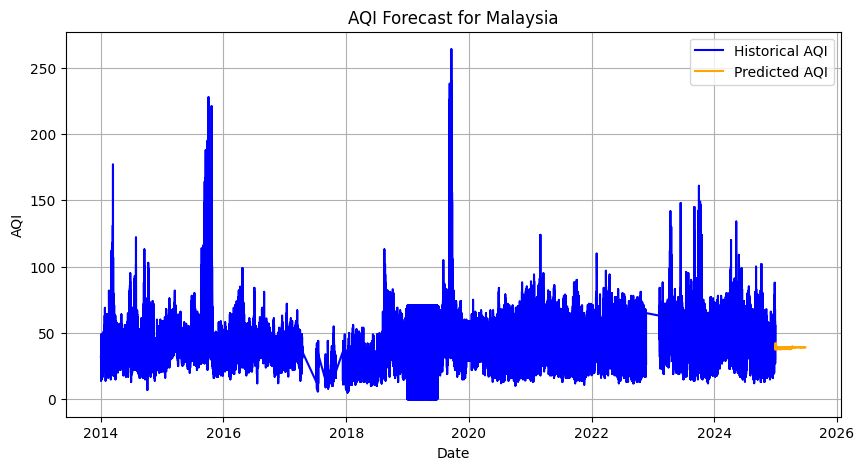

Processing Country: Singapore
Model Performance on Test Set:
R²: 0.572
MAE: 6.785
RMSE: 8.410
Predicted AQI for Singapore (Next 6 Months):
        Date  Predicted_AQI
0 2024-01-01      42.618121
1 2024-01-02      39.910486
2 2024-01-03      43.312258
3 2024-01-04      41.743088
4 2024-01-05      41.821529
5 2024-01-06      40.032087
6 2024-01-07      41.565394
7 2024-01-08      40.511349
8 2024-01-09      40.847933
9 2024-01-10      40.404188
...


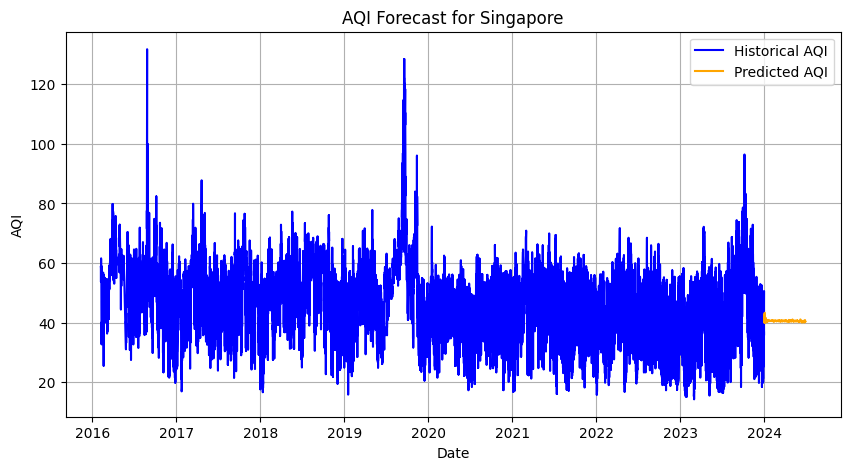

Processing Country: Thailand
Model Performance on Test Set:
R²: 0.613
MAE: 13.345
RMSE: 20.217
Predicted AQI for Thailand (Next 6 Months):
        Date  Predicted_AQI
0 2025-01-01     127.151716
1 2025-01-02     115.110258
2 2025-01-03     118.304800
3 2025-01-04     115.768791
4 2025-01-05     106.189218
5 2025-01-06     104.729938
6 2025-01-07     104.476401
7 2025-01-08     116.109181
8 2025-01-09     114.223341
9 2025-01-10     114.038399
...


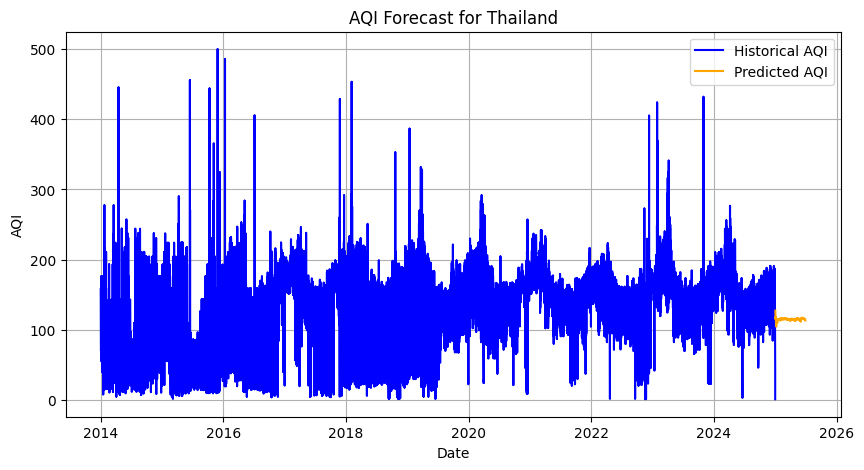

In [6]:
# Cell 10: Process each country separately (entire loop must remain as one block)
for country in countries:
    print("="*60)
    print(f"Processing Country: {country}")
    print("="*60)

    country_data = df[df['Country'] == country].sort_values('Date').copy()

    # Time-based features
    country_data['month'] = country_data['Date'].dt.month
    country_data['day'] = country_data['Date'].dt.day
    country_data['dayofweek'] = country_data['Date'].dt.dayofweek
    country_data['year'] = country_data['Date'].dt.year

    # Lag features
    for lag in [1, 3, 7]:
        country_data[f'aqi_lag_{lag}'] = country_data['AQI'].shift(lag)

    # Rolling window stats (new powerful features)
    country_data['aqi_roll_mean_7'] = country_data['AQI'].rolling(window=7).mean()
    country_data['aqi_roll_std_7'] = country_data['AQI'].rolling(window=7).std()

    # Interaction feature
    country_data['Temp_Humidity_Interaction'] = country_data['Temperature'] * country_data['RelativeHumidity']

    # Drop missing after feature creation
    country_data = country_data.dropna()

    # Define features
    features = [
        'Temperature', 'RelativeHumidity', 'WindSpeed',
        'month', 'day', 'dayofweek',
        'aqi_lag_1', 'aqi_lag_3', 'aqi_lag_7',
        'aqi_roll_mean_7', 'aqi_roll_std_7',
        'Temp_Humidity_Interaction'
    ]

    X = country_data[features]
    y = country_data['AQI']

    # Split sets (keep temporal order)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    # Improved Random Forest
    model = RandomForestRegressor(
        n_estimators=400,
        max_depth=18,
        min_samples_split=3,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # Evaluate performance
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print("Model Performance on Test Set:")
    print(f"R²: {r2:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")

    # Predict next 6 months
    last_known = country_data.iloc[-7:].copy()
    future_dates = pd.date_range(start=country_data['Date'].max() + timedelta(days=1), periods=180)

    predictions = []
    for next_date in future_dates:
        next_row = {
            'Temperature': last_known['Temperature'].mean(),
            'RelativeHumidity': last_known['RelativeHumidity'].mean(),
            'WindSpeed': last_known['WindSpeed'].mean(),
            'month': next_date.month,
            'day': next_date.day,
            'dayofweek': next_date.dayofweek,
            'aqi_lag_1': last_known['AQI'].iloc[-1],
            'aqi_lag_3': last_known['AQI'].iloc[-3],
            'aqi_lag_7': last_known['AQI'].iloc[-7],
            'aqi_roll_mean_7': last_known['AQI'].rolling(7).mean().iloc[-1],
            'aqi_roll_std_7': last_known['AQI'].rolling(7).std().iloc[-1],
            'Temp_Humidity_Interaction': (
                last_known['Temperature'].mean() * last_known['RelativeHumidity'].mean()
            )
        }

        next_pred = model.predict(pd.DataFrame([next_row]))[0]
        predictions.append(next_pred)

        new_row = pd.DataFrame({'Date': [next_date], 'AQI': [next_pred],
                                'Temperature': [next_row['Temperature']],
                                'RelativeHumidity': [next_row['RelativeHumidity']],
                                'WindSpeed': [next_row['WindSpeed']]})
        last_known = pd.concat([last_known, new_row]).iloc[1:]

    future_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted_AQI': predictions
    })

    print("Predicted AQI for", country, "(Next 6 Months):")
    print(future_df.head(10))
    print("...")

    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(country_data['Date'], country_data['AQI'], label='Historical AQI', color='blue')
    plt.plot(future_df['Date'], future_df['Predicted_AQI'], label='Predicted AQI', color='orange')
    plt.title(f"AQI Forecast for {country}")
    plt.xlabel("Date")
    plt.ylabel("AQI")
    plt.legend()
    plt.grid(True)
    plt.show()
